# African Credit Scoring Challenge - Baseline Notebook 


## <a id="1"></a>Introduction
This notebook provides a baseline approach for the African Credit Scoring Challenge. We will:
- Load and understand the credit scoring data
- Perform exploratory data analysis
- Create and evaluate a machine learning model
- Generate predictions for submission

Key aspects of this challenge:
- Predicting loan defaults in African markets
- Dealing with imbalanced data
- Building models that can generalize to new regions

In [1]:
# === Import Libraries ===
# Data manipulation and analysis

# Settings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from scipy.stats import mode

# Advanced ML Models
from imblearn.over_sampling import BorderlineSMOTE
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier



## <a id="2"></a>Data Loading and Inspection
Let's load our training and test datasets and examine their basic properties.

In [ ]:
# Loading the train dataset
train = pd.read_csv('/data/Train.csv')
test = pd.read_csv('/data/Test.csv')
# Display the first few rows of the datasets and their shape
display("Train", train.head(), train.shape, "Test", test.head(), test.shape)

'Train'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


(68654, 16)

'Test'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


(18594, 15)

In [3]:
# Examine data types and check for missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   country_id                   68654 non-null  object 
 3   tbl_loan_id                  68654 non-null  int64  
 4   lender_id                    68654 non-null  int64  
 5   loan_type                    68654 non-null  object 
 6   Total_Amount                 68654 non-null  float64
 7   Total_Amount_to_Repay        68654 non-null  float64
 8   disbursement_date            68654 non-null  object 
 9   due_date                     68654 non-null  object 
 10  duration                     68654 non-null  int64  
 11  New_versus_Repeat            68654 non-null  object 
 12  Amount_Funded_By_Lender      68654 non-null  float64
 13  Lender_portion_F

In [4]:
# Check for missing values in the train dataset
print(f"There are {train.isna().sum().sum()} missing values in the data.")

There are 0 missing values in the data.


## <a id="4"></a>Exploratory Data Analysis (EDA)
We'll create visualization helper functions to understand our data distribution.

In [5]:
def plot_continuous(df, column, transform=None):
    """
    Creates visualization for continuous variables with optional transformations.
    
    Parameters:
    df (DataFrame): Input dataframe
    column (str): Column name to visualize
    transform (str): Type of transformation ('log' or 'sqrt')
    """
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    
    # Original data plots
    sns.histplot(df[column], kde=True, ax=axs[0, 0])
    axs[0, 0].set_title(f'Distribution of {column}')
    axs[0, 0].set_xlabel(column)

    sns.boxplot(y=df[column], ax=axs[1, 0])
    axs[1, 0].set_title(f'Box Plot of {column}')
    axs[1, 0].set_ylabel(column)

    if transform == 'log':
        transformed_data = np.log1p(df[column])
        transform_label = 'Log'
    elif transform == 'sqrt':
        transformed_data = np.sqrt(df[column])
        transform_label = 'Square Root'
    else:
        transformed_data = None

    if transformed_data is not None:
        sns.histplot(transformed_data, kde=True, ax=axs[0, 1])
        axs[0, 1].set_title(f'{transform_label} Distribution of {column}')
        axs[0, 1].set_xlabel(f'{transform_label}({column})')

        sns.boxplot(y=transformed_data, ax=axs[1, 1])
        axs[1, 1].set_title(f'{transform_label} Box Plot of {column}')
        axs[1, 1].set_ylabel(f'{transform_label}({column})')
    else:
        for ax in [axs[0, 1], axs[1, 1]]:
            ax.remove()

    plt.tight_layout()
    plt.show()

def plot_categorical(df, column):
    """
    Creates visualization for categorical variables.
    
    Parameters:
    df (DataFrame): Input dataframe
    column (str): Column name to visualize
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    value_counts = df[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax1)
    ax1.set_title(f'Bar Plot of {column}')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)

    ax2.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
    ax2.set_title(f'Pie Chart of {column}')

    plt.tight_layout()
    plt.show()

### Categorical Variables Analysis
Let's explore the distribution of categorical variables in our dataset.

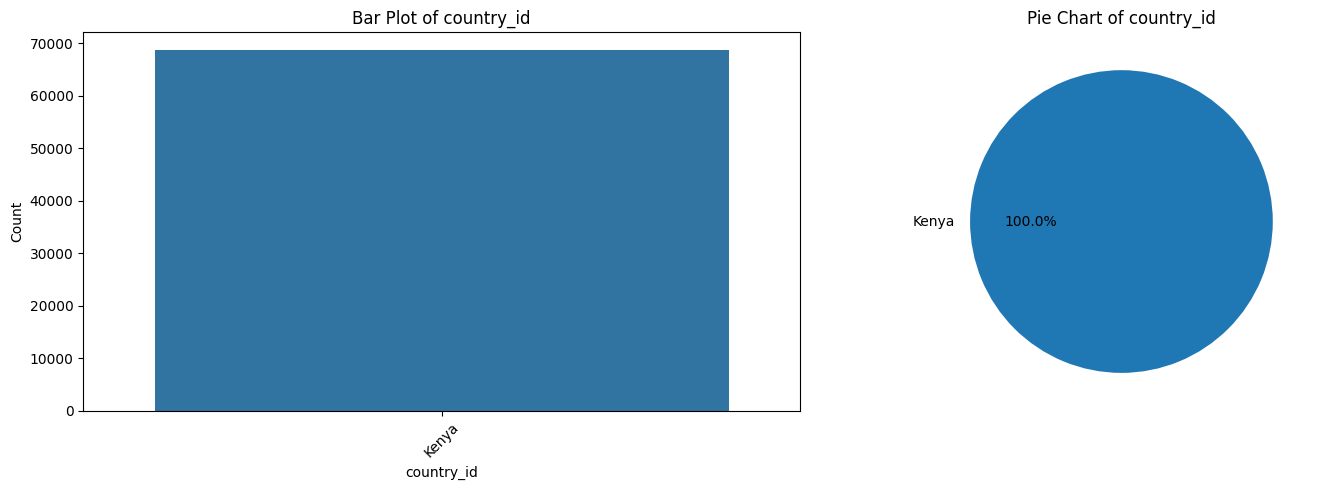

In [6]:
# Analyze country distribution in train set
plot_categorical(train, 'country_id')

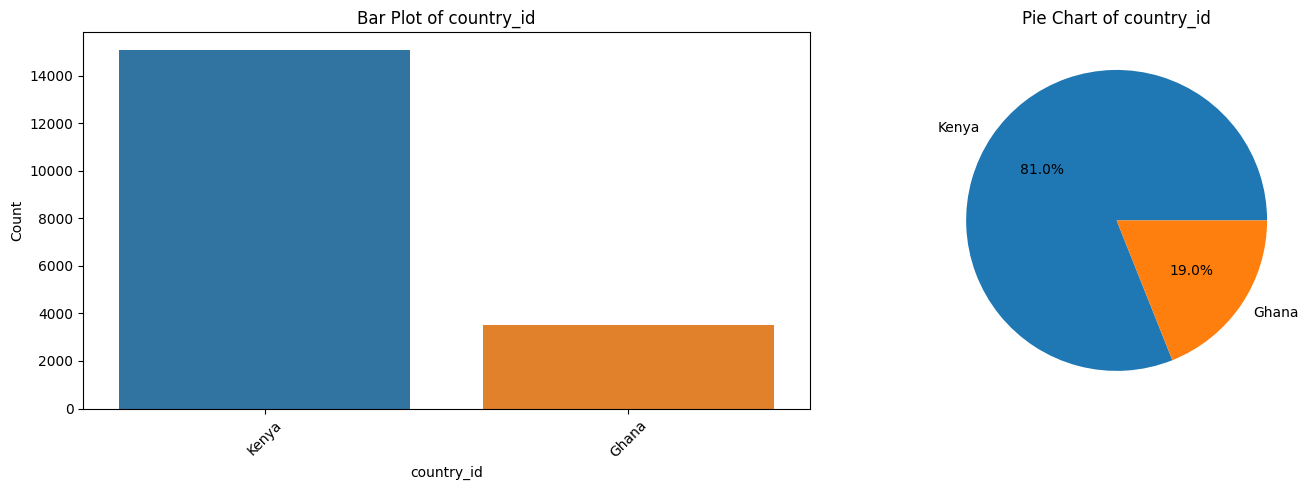

In [7]:
# Analyze country distribution in test set
plot_categorical(test, 'country_id')

**Important Note:** The test set includes Ghana, which is not present in the training data. This indicates we need to build a model that can generalize well to new regions.

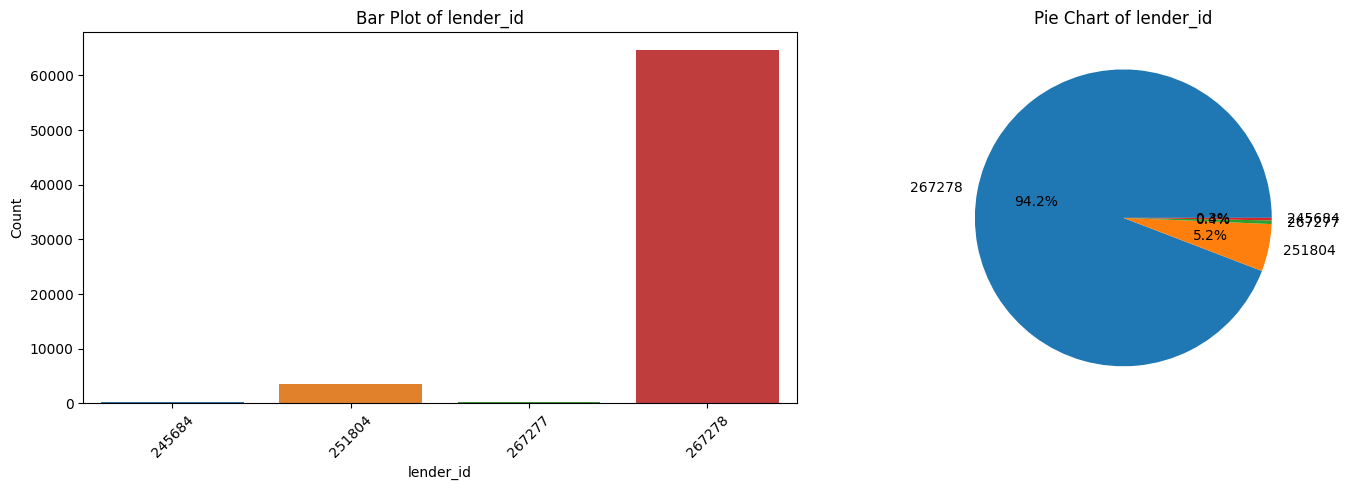

In [8]:
# Analyze lender distribution
plot_categorical(train, 'lender_id')

### Target Variable Analysis
Let's examine our target variable distribution.

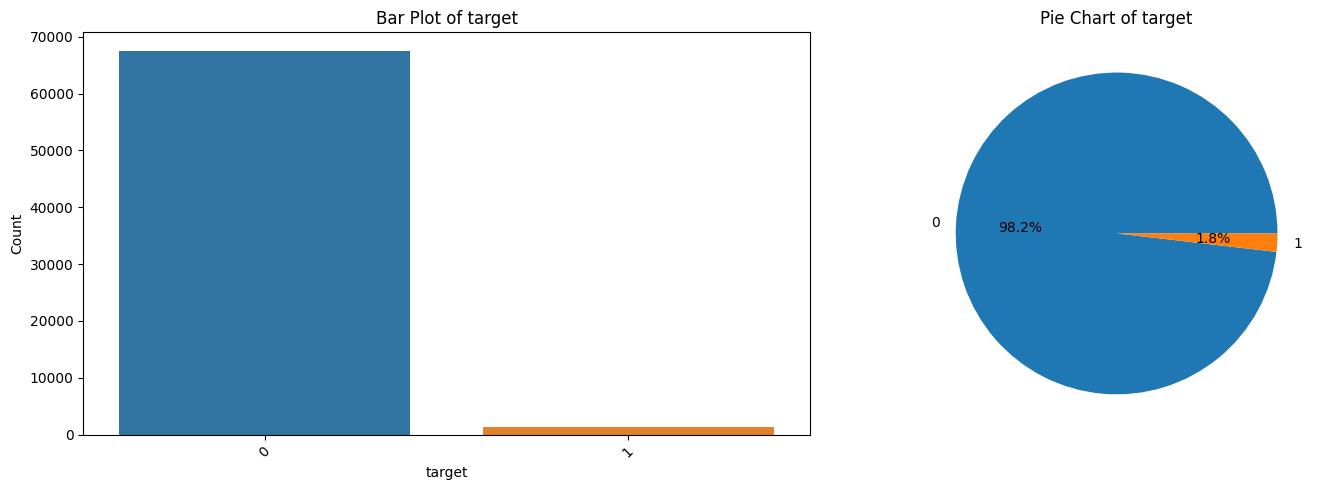

In [9]:
# Analyze target variable distribution
plot_categorical(train, 'target')

**Key Insight:** The dataset is highly imbalanced, which is typical for loan default scenarios.

### Continuous Variables Analysis
Let's examine the distribution of numerical variables.

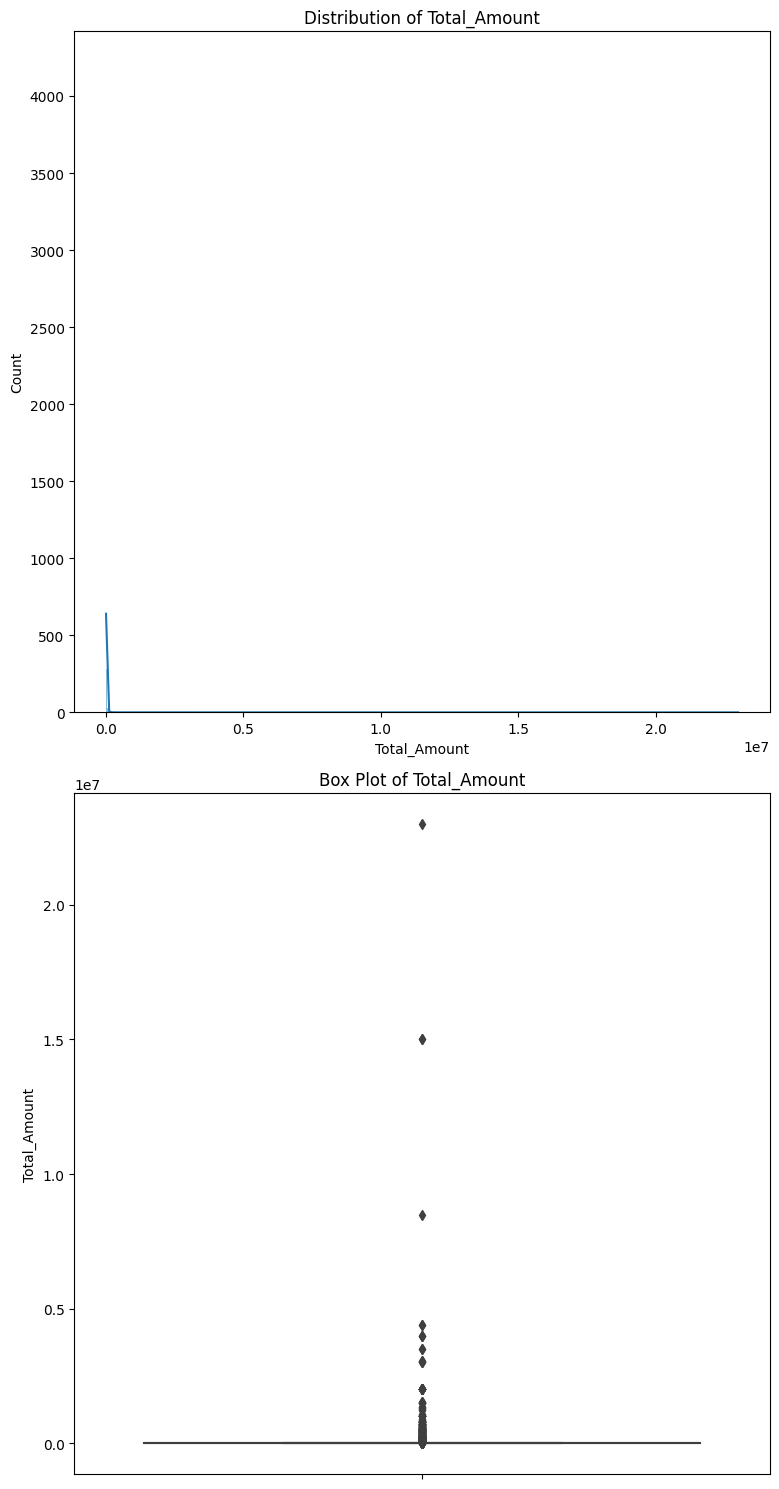

In [10]:
# Analyze Total Amount distribution
plot_continuous(train, 'Total_Amount')

## <a id="5"></a>Feature Engineering
We'll combine train and test data for consistent feature engineering.

In [11]:
# Combine datasets for consistent feature engineering
data = pd.concat([train, test]).reset_index(drop=True)

# Convert date columns to datetime
data['disbursement_date'] = pd.to_datetime(data['disbursement_date'], errors='coerce')
data['due_date'] = pd.to_datetime(data['due_date'], errors='coerce')

# update total amount to repay to the the lender portion to be repaid where total amount to be repaid is 0
data.loc[data['Total_Amount_to_Repay'] == 0, ['Total_Amount_to_Repay']] += data['Lender_portion_to_be_repaid']

# Compute mena and median values by customer for the total amount to repay
aggregates = data.groupby('customer_id')['Total_Amount_to_Repay'].agg(['mean', 'median']).reset_index()
aggregates.rename(columns={'mean': 'Mean_Total_Amount', 'median': 'Median_Total_Amount'}, inplace=True)
data=data.merge(aggregates, on='customer_id', how='left')


# Extract temporal features from dates
date_cols = ['disbursement_date', 'due_date']
for col in date_cols:
    data[col] = pd.to_datetime(data[col])
    # Extract month, day, year
    data[col+'_month'] = data[col].dt.month
    data[col+'_day'] = data[col].dt.day
    data[col+'_year'] = data[col].dt.year
    # Calculate loan term and weekday features
    data[f'loan_term_days'] = (data['due_date'] - data['disbursement_date']).dt.days
    data[f'disbursement_weekday'] = data['disbursement_date'].dt.weekday
    data[f'due_weekday'] = data['due_date'].dt.weekday

# Create some financial ratios and transformations
data['repayment_ratio'] = data['Total_Amount_to_Repay'] / data['Total_Amount']
data['amount_due_per_day'] = (data['Total_Amount_to_Repay'] / data['duration'])
data['log_Total_Amount'] = np.log1p(data['Total_Amount'])
data['log_Total_Amount_to_Repay'] = np.log1p(data['Total_Amount_to_Repay']) 
data['log_Amount_Funded_By_Lender'] = np.log1p(data['Amount_Funded_By_Lender'])
data['log_Lender_portion_to_be_repaid'] = np.log1p(data['Lender_portion_to_be_repaid'])
data['amount_to_repay_greater_than_average']=data['Mean_Total_Amount'] - data['Total_Amount_to_Repay'] 

#some outliers were noticed in the total amount and total amount to repay fields. 
# offset this by using the 90th percentile
q=0.9
data['Total_Amount_to_Repay'] = np.where(data['Total_Amount_to_Repay'] >= data['Total_Amount_to_Repay'].quantile(q), data['Total_Amount_to_Repay'].quantile(q),data['Total_Amount_to_Repay'])
data['Total_Amount'] = np.where(data['Total_Amount'] >= data['Total_Amount'].quantile(q), data['Total_Amount'].quantile(q),data['Total_Amount'])

# Handle categorical variables
cat_cols = data.select_dtypes(include='object').columns

# Label encoding for other categorical columns
le = LabelEncoder()
for col in [col for col in cat_cols if col not in ['loan_type', 'ID']]:
    data[col] = le.fit_transform(data[col])

# Split back into train and test
train_df = (data[data['ID'].isin(train['ID'].unique())]).fillna(0)
test_df = (data[data['ID'].isin(test['ID'].unique())]).fillna(0)

# Define features for modeling
features_for_modelling = [col for col in train_df.columns if col not in date_cols + ['ID', 'target', 'country_id','loan_type']]

print(f"The shape of train_df is: {train_df.shape}")
print(f"The shape of test_df is: {test_df.shape}")
print(f"The shape of train is: {train.shape}")
print(f"The shape of test is: {test.shape}")
print(f"The features for modelling are:\n{features_for_modelling}")


The shape of train_df is: (68654, 34)
The shape of test_df is: (18594, 34)
The shape of train is: (68654, 16)
The shape of test is: (18594, 15)
The features for modelling are:
['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'New_versus_Repeat', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'Mean_Total_Amount', 'Median_Total_Amount', 'disbursement_date_month', 'disbursement_date_day', 'disbursement_date_year', 'loan_term_days', 'disbursement_weekday', 'due_weekday', 'due_date_month', 'due_date_day', 'due_date_year', 'repayment_ratio', 'amount_due_per_day', 'log_Total_Amount', 'log_Total_Amount_to_Repay', 'log_Amount_Funded_By_Lender', 'log_Lender_portion_to_be_repaid', 'amount_to_repay_greater_than_average']


## <a id="6"></a>Model Development
### Cross Validation
We'll use stratified split due to class imbalance.

In [12]:

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

### Model Training and Optimization

In [13]:
xgb_best_params= {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.09952819042992249, 'subsample': 0.9138294343870095, 'colsample_bytree': 0.6808646076666579, 'gamma': 0.01070807358962328, 'min_child_weight': 1}
lgb_best_params=  {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.07587945476302646, 'num_leaves': 70, 'feature_fraction': 0.6624074561769746, 'bagging_fraction': 0.662397808134481, 'lambda_l1': 0.05808361216819946, 'lambda_l2': 0.8661761457749352}
cat_best_params= {'iterations': 500, 'depth': 7, 'learning_rate': 0.09702561867586006}


In [31]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')


# Coss validate model performance

seed=42

X,y=train_df[features_for_modelling], train_df['target']

cv_reports = []
f1_scores = []
predictions=[]
pred_prob=[]
base_estimator = DecisionTreeClassifier()
for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y),1):
    
    X_fold_train = X.iloc[train_idx]
    X_fold_valid = X.iloc[valid_idx]
    y_fold_train = y.iloc[train_idx]
    y_fold_valid = y.iloc[valid_idx]
    
    smote =BorderlineSMOTE(sampling_strategy=0.45, random_state=seed)
    
    # Apply SMOTE only on the training data of this fold
    X_fold_train_smote, y_fold_train_smote = smote.fit_resample(X_fold_train, y_fold_train)
    
    # Calculate scale_pos_weight to mitigate class imbalance
    scale_pos_weight = len(y_fold_train_smote[y_fold_train_smote == 1])*0.75 / len(y_fold_train_smote[y_fold_train_smote == 0]) 
    
    model1 = xgb.XGBClassifier(**xgb_best_params,scale_pos_weight=scale_pos_weight,random_state=seed)
    model2 = LGBMClassifier(**lgb_best_params,scale_pos_weight=scale_pos_weight,random_state=seed)
    model3 = CatBoostClassifier(**cat_best_params,scale_pos_weight=scale_pos_weight,random_state=seed)
    

     
    # Train the model on the SMOTE-balanced fold
    model1.fit(X_fold_train_smote, y_fold_train_smote)
    model2.fit(X_fold_train_smote, y_fold_train_smote)
    model3.fit(X_fold_train_smote, y_fold_train_smote)
   

    # predict on validation set
    pred_1 = model1.predict(X_fold_valid)
    pred_2 = model2.predict(X_fold_valid)
    pred_3 = model3.predict(X_fold_valid)

    predictions = mode([pred_1,pred_2,pred_3], axis=0).mode.flatten()

    report = classification_report(y_fold_valid,predictions, output_dict=True)
    cv_reports.append(report)
        
        # Calculate and store the f1 score for this fold
    f1 = f1_score(predictions, y_fold_valid)
    f1_scores.append(f1)


    print(f"Fold {fold} Classification Report:")
    print(classification_report(y_fold_valid, predictions))
    print(f"Fold {fold} F1 Score: {f1:.4f}")
    print("-" * 50)

    # Summary of CV results
    print(f"Mean F1 Score across folds: {np.mean(f1_scores):.4f}")
  

[LightGBM] [Warning] feature_fraction is set=0.6624074561769746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6624074561769746
[LightGBM] [Warning] lambda_l2 is set=0.8661761457749352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8661761457749352
[LightGBM] [Warning] lambda_l1 is set=0.05808361216819946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05808361216819946
[LightGBM] [Warning] bagging_fraction is set=0.662397808134481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.662397808134481
[LightGBM] [Warning] feature_fraction is set=0.6624074561769746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6624074561769746
[LightGBM] [Warning] lambda_l2 is set=0.8661761457749352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8661761457749352
[LightGBM] [Warning] lambda_l1 is set=0.05808361216819946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05808361216819946
[LightGBM

### Test data Prediction using Models

In [15]:

X,y=train_df[features_for_modelling], train_df['target']

predictions=[]
pred_prob=[]
base_estimator = DecisionTreeClassifier()
for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y),1):
    
    X_fold_train = X.iloc[train_idx]
    X_fold_valid = X.iloc[valid_idx]
    y_fold_train = y.iloc[train_idx]
    y_fold_valid = y.iloc[valid_idx]
    
    smote =BorderlineSMOTE(sampling_strategy=0.45, random_state=seed)
    
    # Apply SMOTE only on the training data of this fold
    X_fold_train_smote, y_fold_train_smote = smote.fit_resample(X_fold_train, y_fold_train)
        # Calculate scale_pos_weight
    scale_pos_weight = len(y_fold_train_smote[y_fold_train_smote == 1])*0.75 / len(y_fold_train_smote[y_fold_train_smote == 0]) 
    
    model1 = xgb.XGBClassifier(**xgb_best_params,scale_pos_weight=scale_pos_weight,random_state=seed)
    model2 = LGBMClassifier(**lgb_best_params,scale_pos_weight=scale_pos_weight,random_state=seed)
    model3 = CatBoostClassifier(**cat_best_params,scale_pos_weight=scale_pos_weight,random_state=seed)
    
     
    # Train the model on the SMOTE-balanced fold
    model1.fit(X_fold_train_smote, y_fold_train_smote)
    model2.fit(X_fold_train_smote, y_fold_train_smote)
    model3.fit(X_fold_train_smote, y_fold_train_smote)
    

    # make predictions using models
    pred_1 = model1.predict(test_df[features_for_modelling])
    pred_2 = model2.predict(test_df[features_for_modelling])
    pred_3 = model3.predict(test_df[features_for_modelling])
    pred_p_1 = model1.predict_proba(test_df[features_for_modelling])
    pred_p_2 = model2.predict_proba(test_df[features_for_modelling])
    pred_p_3 = model3.predict_proba(test_df[features_for_modelling])


    #Append predictions
    predictions.append(pred_1)
    predictions.append(pred_2)
    predictions.append(pred_3)
    pred_prob.append(pred_p_1)
    pred_prob.append(pred_p_2)
    pred_prob.append(pred_p_3)
   

[LightGBM] [Warning] feature_fraction is set=0.6624074561769746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6624074561769746
[LightGBM] [Warning] lambda_l2 is set=0.8661761457749352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8661761457749352
[LightGBM] [Warning] lambda_l1 is set=0.05808361216819946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05808361216819946
[LightGBM] [Warning] bagging_fraction is set=0.662397808134481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.662397808134481
[LightGBM] [Warning] feature_fraction is set=0.6624074561769746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6624074561769746
[LightGBM] [Warning] lambda_l2 is set=0.8661761457749352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8661761457749352
[LightGBM] [Warning] lambda_l1 is set=0.05808361216819946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05808361216819946
[LightGBM

In [16]:

final_predictions = mode(predictions, axis=0).mode.flatten()
final_pred_proba=np.mean(pred_prob,axis=0)
test_df['target'] = final_predictions
test_df[['proba','proba2']]= final_pred_proba

In [17]:
test_df.target.sum()

651.0

### Post Process the predictions for better score

In [18]:
# concat and sort train and test data for easy post processing
train_test=pd.concat([train_df,test_df])
train_test=(train_test.sort_values(['customer_id','tbl_loan_id','disbursement_date','duration'])).reset_index(drop=True)

In [19]:
# Post Processing functions

def check_loanid_in_train_data(tbl_loan_id):
    '''
    The function checks loans in the test data and update the target to the
    value available in the training data. The intuition behind this is that 
    a loan can only have one decision (0 or 1) and the target in the training data 
    supercedes that of the test data
    '''
    # Check if tbl_loan_id exists in the train DataFrame
    if tbl_loan_id in train_df['tbl_loan_id'].values:
        df = train_df[train_df['tbl_loan_id'] == tbl_loan_id]
        target=df.target.values[0]
    else:
        target=3  # Returns a 3 if there is no match
    return target

    
def type_3_correction (df):
    '''
    The model performed poorly in the type 3 loan type in the Ghana dataset.
    The distribution for that loan type differs to the distribution in the training data
    e.g. The repayment ratio for this loan type is generally much lower than the training dataset
    making the model to predict 0 for all instances (over 3000 instances).
    From the EDAs, it is impossible that all loans in such a class to have just one target group.
    To offset this, an assumption that loans were being disbursed to the customer untill he fails to pay was made.
    This function executes this assumption
    '''
    df1=df[df['loan_type']=='Type_3']
    customer_id=df1.customer_id.unique()
    for customer in customer_id:
        loan_id=df[df['customer_id']==customer].tail(1).tbl_loan_id.values[0]
        df.loc[df['tbl_loan_id'] == loan_id, 'target'] = 1   
    return df


def correct_loan_ids_with_conflicting_target(df):
    '''
    This function ensures that loans only have one target group (0 or 1 not both)
    even if there is more than one lender.
    '''
    # Find loan_ids with different target values
    loan_ids_with_diff_targets = df.groupby('tbl_loan_id')['target'].transform('nunique') > 1

    # Update target values to 1 for those loan_ids
    df.loc[loan_ids_with_diff_targets, 'target'] = 0
    return df    

In [20]:
# Run through the DataFrame and apply the logic explained in the preceeding cell
for i in range(len(train_test)):
    if pd.notna(train_test.loc[i, 'proba']):
        customer_id=train_test.loc[i, 'customer_id']
            
        tbl_loan_id = train_test.loc[i, 'tbl_loan_id']
        target=check_loanid_in_train_data(tbl_loan_id)
            
        if target <2:
            train_test.loc[i, 'target']=target

train_test_f=type_3_correction (train_test)
correct_loan_ids_with_conflicting_target(train_test_f)
test_df=train_test_f[train_test_f['proba'].notna()]

In [21]:
sub =  test_df[['ID', 'target']]
sub.head()

sub.to_csv('final_submission.csv', index=False)
sub.target.sum()

1020.0

In [33]:
import joblib

# Save models
joblib.dump(model1, '/kaggle/working/model1.pkl')
joblib.dump(model2, '/kaggle/working/model2.pkl')
joblib.dump(model3, '/kaggle/working/model3.pkl')


['/kaggle/working/model3.pkl']

## <a id="1"></a>Credit Score Function
To build the credit score function, the following were considered:
- Probability of default: This is one of the models ouputs. The higher the probability, the higher the possibility of default.
- The loan history length: This is the number of historical loans granted to the customer. The higher the number, the higher the credit score.
- The number of defaults: This is the number of times the customer has defaulted. The higher the number, the lower the credit score.
- The credit score is capped between 300 and 850 to comply with the mostly used standards.
 

In [22]:
# Group by customer_id
# calculate the number of loans and defaults

credit_score_calc = train_test_f.groupby('customer_id').agg(
    distinct_loans=('tbl_loan_id', 'nunique'),
    count_default=('target', 'sum')
).reset_index()


In [23]:
credit_score_calc.head() 

,customer_id,distinct_loans,count_default
0,145,1,0.0
1,161,1,0.0
2,166,1,0.0
3,1487,1,0.0
4,4534,2,0.0


In [24]:

train_test_f=train_test_f.merge(credit_score_calc, on=['customer_id'])
train_test_f.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,...,amount_due_per_day,log_Total_Amount,log_Total_Amount_to_Repay,log_Amount_Funded_By_Lender,log_Lender_portion_to_be_repaid,amount_to_repay_greater_than_average,proba,proba2,distinct_loans,count_default
0,ID_145124016245684,145,1,124016,245684,Type_11,14500.0,15738.0,2022-03-09,2022-04-08,...,524.600000,9.581973,9.663897,9.210440,9.292381,0.0,NaN,NaN,1,0.0
1,ID_161361065267277,161,1,361065,267277,Type_9,11025.0,11686.5,2024-01-15,2024-02-14,...,389.550000,9.308011,9.366275,8.318254,8.376551,0.0,NaN,NaN,1,0.0
2,ID_166124634245684,166,1,124634,245684,Type_11,5881.0,6914.0,2022-03-11,2022-04-10,...,230.466667,8.679652,8.841448,8.679652,8.841448,0.0,NaN,NaN,1,0.0
3,ID_1487125800245684,1487,1,125800,245684,Type_11,7000.0,7850.0,2022-03-14,2022-04-13,...,261.666667,8.853808,8.968396,8.853808,8.968396,0.0,NaN,NaN,1,0.0
4,ID_4534122904245684,4534,1,122904,245684,Type_11,9565.0,10672.0,2022-03-07,2022-04-06,...,355.733333,9.165970,9.275472,9.165970,9.275472,16366.5,NaN,NaN,2,0.0


In [25]:
# Calculate credit scores for the test datasets
test_df=train_test_f[train_test_f['proba'].notna()]

In [26]:

def credit_score(prob_default, default_payment_count, loan_amount, loan_history_length):
    """
    Compute a credit score based on model output and other financial factors.
    
    :param prob_default: Probability of default (output of the model, between 0 and 1)
    :param default_payment_count: Number of defaults in payment in the customer's history
    :param loan_amount: Total_Amount requested
    :param loan_history_length: Length of loans in the customer's history
    :return: Credit score (scaled between 300 and 850)
    """
    
    # Define weights for each factor
    # The defined weights are only suggections and can be adjusted based on available data for better credit scoring
    
    weight_probab_default = -400  # High penalty for high probability of default 
    weight_default_payments = -20  # Each late payment reduces score
    weight_loan_history_length = 5  # Longer credit history increases score
    
        
    # Compute raw score
    raw_score = (
        850 + 
        weight_probab_default * prob_default +
        weight_default_payments * default_payment_count +
        weight_loan_history_length * loan_history_length
    )
    
    # Ensure score is within 300-850 range
    credit_score = np.clip(raw_score, 300, 850)
    
    return round(credit_score)



In [27]:
#An example of how to use it with the models outputs

test_df['credit_score'] = test_df.apply(
    lambda row: credit_score(row['proba2'], row['count_default'], row['Total_Amount'], row['distinct_loans']),
    axis=1
)

In [28]:
test_df.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,...,log_Total_Amount,log_Total_Amount_to_Repay,log_Amount_Funded_By_Lender,log_Lender_portion_to_be_repaid,amount_to_repay_greater_than_average,proba,proba2,distinct_loans,count_default,credit_score
7,ID_6083142641251804,6083,1,142641,251804,Type_4,10000.0,10700.0,2022-04-13,2022-05-13,...,9.210440,9.278092,7.378384,7.446001,2224.0,0.997480,0.002520,5,0.0,850
10,ID_6083212266267278,6083,1,212266,267278,Type_4,13500.0,14445.0,2022-07-10,2022-08-09,...,9.510519,9.578173,7.678326,7.745868,-1521.0,0.999091,0.000909,5,0.0,850
13,ID_7154223193267278,7154,1,223193,267278,Type_1,25168.0,26130.4,2022-07-23,2022-07-30,...,10.269102,10.299104,9.065211,9.095266,-5622.0,0.999987,0.000013,18,0.0,850
17,ID_7154238379267278,7154,1,238379,267278,Type_1,25168.0,26130.4,2022-08-17,2022-08-24,...,10.236525,10.266532,8.576122,8.606119,-4670.0,0.999943,0.000057,18,0.0,850
23,ID_7154279438267278,7154,1,279438,267278,Type_1,25168.0,26130.4,2022-10-11,2022-10-18,...,10.379007,10.409009,6.036796,6.066108,-9073.0,0.999980,0.000020,18,0.0,850


In [29]:
test_df.credit_score.unique()

array([850, 842, 787, 824, 418, 436, 844, 825, 459, 443, 727, 601, 435,
       437, 847, 439, 820, 442, 831, 821, 765, 485, 801, 839, 846, 796,
       827, 829, 835, 840, 483, 568, 807, 429, 793, 804, 542, 507, 718,
       748, 440, 441, 790, 733, 834, 481, 469, 816, 628, 817, 818, 638,
       515, 849, 425, 755, 535, 833, 766, 695, 438, 470, 780, 828, 729,
       396, 476, 830, 705, 775, 496, 811, 575, 670, 783, 448, 584, 843,
       701, 461, 838, 845, 445, 800, 799, 848, 466, 460, 596, 710, 671,
       450, 455, 551, 521, 529, 473, 478, 536, 549, 528, 471, 684, 573,
       654, 465, 632, 468, 501, 488, 837, 543, 595, 505, 813, 808, 486,
       524, 598, 511, 653, 446, 832, 451, 480, 447, 776, 789, 432, 617,
       502, 822, 682, 677, 614, 591, 747, 692, 700, 474, 420, 472, 665,
       651, 774, 603, 734, 707, 421, 417, 674, 699, 749, 836, 809, 590,
       779, 659, 690, 610, 422, 826, 797, 626, 678, 716, 691, 430, 570,
       786, 673, 415, 795, 530, 586, 495, 520, 510, 607, 676, 70

## <a id="1"></a>Credit Score Ranges
- 300–579: Poor
- 580–669: Fair
- 670–739: Good
- 740–799: Very good
- 800–850: Excellent






## If the income of the customer is available, the function below can be used as it incorporates the income of the customer. Doing this may improve the credit score calculation

In [30]:
def credit_score(prob_default, default_payment_count, loan_amount, loan_history_length,income):
    """
    Compute a credit score based on model output and other financial factors.
    
    :param prob_default: Probability of default (output of the model, between 0 and 1)
    :param default_payment_count: Number of defaults in payment in the customer's history
    :param loan_amount: Total_Amount requested
    :param income: The income of the customer
    :param loan_history_length: Length of loans in the customer's history
    :return: Credit score (scaled between 300 and 850)
    """
    
     # Define weights for each factor
    # The defined weights are only suggections and can be adjusted based on available data for better credit scoring
    
    weight_probab_default = -400  # High penalty for high probability of default 
    weight_default_payments = -20  # Each late payment reduces score
    weight_loan_history_length = 5  # Longer credit history increases score
    weight_loan_income_ratio = -100  # High loan relative to income reduces score
    
    
    # Compute loan-to-income ratio
    loan_income_ratio = loan_amount / (income + 1e-6)  # Avoid division by zero
    
    # Compute raw score
    raw_score = (
        850 + 
        weight_probab_default * prob_default +
        weight_default_payments * default_payment_count +
        weight_loan_income_ratio * loan_income_ratio +
        weight_loan_history_length * loan_history_length
    )
    
    # Ensure score is within 300-850 range
    credit_score = np.clip(raw_score, 300, 850)
    
    return round(credit_score)
